# Churn Analysis of Telco Customer database

### 1) Problem Statement


The main objectives of this work is to identify the factors influencing churn and create a model to predict churn.

### 2) Model fitting for Churn prediction

#### 2.1) Import relevant packages

In [56]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier, XGBRegressor
import xgboost
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc,make_scorer, recall_score, mean_absolute_percentage_error
import os
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier

import shap
import joblib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
%pwd

'd:\\Repositories\\ml-churn\\research'

In [4]:
os.chdir("d://Repositories/ml-churn/")

#### 2.2) Corrected dataset

In [5]:
data_df = pd.read_csv("artifacts/data_preprocessing/usable_data.csv")

#### 2.3) Verify the schema

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Dependents               7043 non-null   int64  
 6   State                              7043 non-null   object 
 7   City                               7043 non-null   object 
 8   Zip Code                           7043 non-null   int64  
 9   Latitude                           7043 non-null   float64
 10  Longitude                          7043 non-null   float64
 11  Number of Referrals                7043 non-null   int64

#### 2.4) Apply the pipeline to encode variables

In [7]:
cat_variable_usable = pd.read_csv("research\cat_variables_usable.csv")
cat_variable_usable = list(cat_variable_usable["cat_variables_usable"])

num_variable_usable = pd.read_csv("research/num_variables_usable.csv")
num_variable_usable = list(num_variable_usable["num_variables_usable"])

In [8]:
X_data = data_df[np.concatenate([num_variable_usable, cat_variable_usable])]

In [46]:
numerical_pipeline = Pipeline([
    ("Quantile_transformation", joblib.load("research\quantile_transformer_all_data.pkl")),
    # ("Std_transformation", joblib.load("research\std_transformer_all_data.pkl")),
    # ("PCA_transformation", PCA(9))
])
categorical_pipeline = Pipeline([
    ("One_hot_encoding", OneHotEncoder())
])
preprocessor = ColumnTransformer(transformers=[
    ("Numerical_pipe", numerical_pipeline, num_variable_usable),
    ("Cat_pipeline", categorical_pipeline, cat_variable_usable )
])

Encoded_data  = preprocessor.fit_transform(X_data)

Encoded_df = pd.DataFrame(Encoded_data , columns= preprocessor.get_feature_names_out())


# Cluster_val = pd.DataFrame(joblib.load("D:\Repositories\ml-churn/research\gmm_cluster.pkl").predict(Encoded_df),
#                            columns= ["New_class"])


In [47]:
# numerical_pipeline = Pipeline([
#     ("Quantile_transformation", joblib.load("research\quantile_transformer_all_data.pkl")),
#     # ("Std_transformation", joblib.load("research\std_transformer_all_data.pkl")),
#     # ("PCA_transformation", PCA(9))
# ])
# categorical_pipeline = Pipeline([
#     ("One_hot_encoding", OneHotEncoder())
# ])
# preprocessor = ColumnTransformer(transformers=[
#     ("Numerical_pipe", numerical_pipeline, num_variable_usable),
#     ("Cat_pipeline", categorical_pipeline, cat_variable_usable )
# ])

# Encoded_data  = preprocessor.fit_transform(X_data)

# Encoded_df = pd.DataFrame(Encoded_data , columns= preprocessor.get_feature_names_out())

# Encoded_df = pd.concat([
#     Encoded_df,
#     Cluster_val
# ], axis=1)

#### 2.6) Apply data transformation

In [48]:
# Duplicated_columns = ['Cat_pipeline__Online Backup_No Service','Cat_pipeline__Device Protection Plan_No Service',
#                 'Cat_pipeline__Premium Tech Support_No Service','Cat_pipeline__Streaming TV_No Service',
#                 'Cat_pipeline__Streaming Movies_No Service','Cat_pipeline__Streaming Music_No Service',
#                 'Cat_pipeline__Unlimited Data_No Service']
# Encoded_df_dropped = Encoded_df.drop(Duplicated_columns, axis=1)


### 3) Data split and hyperparameter optimization for XGBoost Classification algorithm

In [65]:
X_train, X_test, y_train, y_test = train_test_split(Encoded_df, data_df["Churn Value"],
                                                    test_size=0.3, random_state=42,
                                                    stratify=data_df["Churn Value"])

# Create a Gaussian Mixture model
xgb = XGBClassifier(objective='binary:logistic', random_state=42)


param_distributions = {
    'n_estimators': [100, 300, 500],
    'eta': [0.005, 0.01],
    'max_depth': [3, 4],
    'alpha': [0.03, 0.06],
    'lambda': [0.06],
    'eval_metric': ['aucpr'],
    'subsample': [0.5, 0.25],
    'colsample_bytree': [0.5, 0.25],
    'gamma': [5, 3, 8],
    'learning_rate': [0.05, 0.01, 0.1],
    'scale_pos_weight': [1.5, 1.0]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # Number of cross-validation folds
    scoring="roc_auc",  # Scoring metric
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # Random seed for reproducibility
)

#### 3.1) Verify if train and test data is stratified

In [66]:
(y_test == 1).sum()/y_test.count()

0.26549929010885

In [67]:
(y_train == 1).sum()/y_train.count()

0.2653144016227181

#### 3.2) Fit the grid

In [68]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.03, 0.06],
                                        'colsample_bytree': [0.5, 0.25],
                                        'eta': [0.005, 0.01],
                                        'eval_metric': ['aucpr'],
                                        'gamma': [5, 3, 8], 'lambda': [0.06],
                                        'learning_rate': [0.05, 0.01, 0.1],
                                        'max_depth': [3, 4],
                                        'n_estimators': [100, 300, 500],
                                        'scale_pos_weight': [1.5, 1.0],
                                        'subsample': [0.5, 0.25]},
                   random_state=42, scoring='roc_auc')

#### 3.3) Inspect the results obtained from grid

In [69]:
random_search.best_estimator_

XGBClassifier(alpha=0.03, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.005, eval_metric='aucpr',
              feature_types=None, gamma=8, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.06,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300, ...)

### Visualize `xgboost` feature importance

<Axes: >

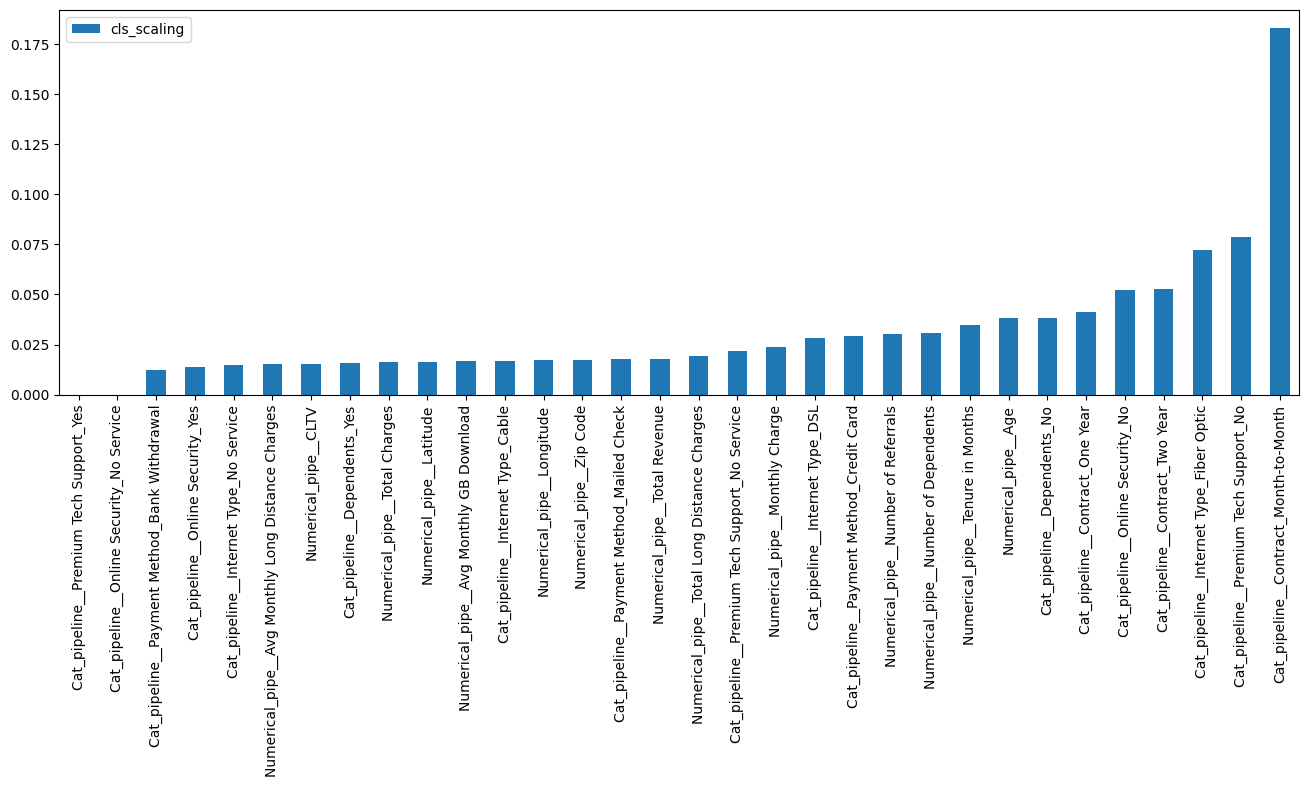

In [70]:
_, ax = plt.subplots(1,1, figsize=(16,5))

pd.DataFrame(random_search.best_estimator_.feature_importances_,
             index=X_train.columns,
             columns= ["cls_scaling"]).sort_values(by="cls_scaling")\
    .plot(kind="bar",ax=ax)


#### 3.5) Visualize the AUC curve and select a <b>THRESHOLD</b>

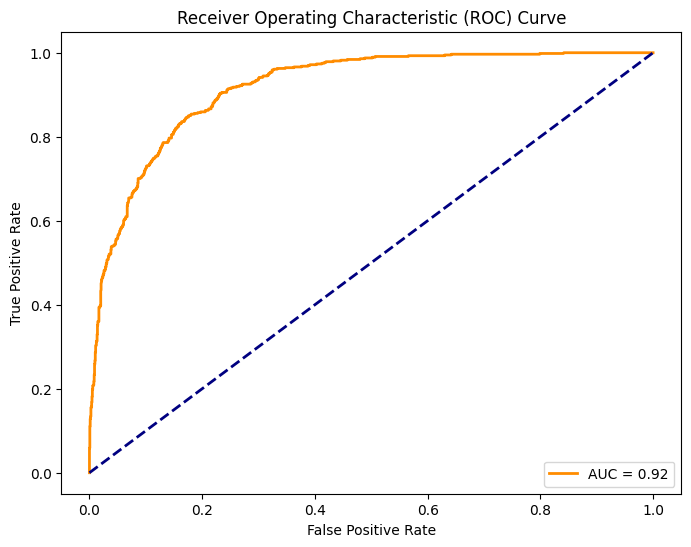

0.9165989029163681

In [71]:
best_model = random_search.best_estimator_
THRESHOLD = 0.4

# Predict probabilities on the test set
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
app_prob = tpr[np.where(np.isclose(THRESHOLD, fpr,rtol=1e-2))]
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.axhline(np.mean(app_prob))
# plt.axvline(THRESHOLD)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
auc(fpr, tpr)

#### 3.6) Calculation of confusion matrix for the proposed THRESHOLD value and compare with the one obtained from the model fit

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


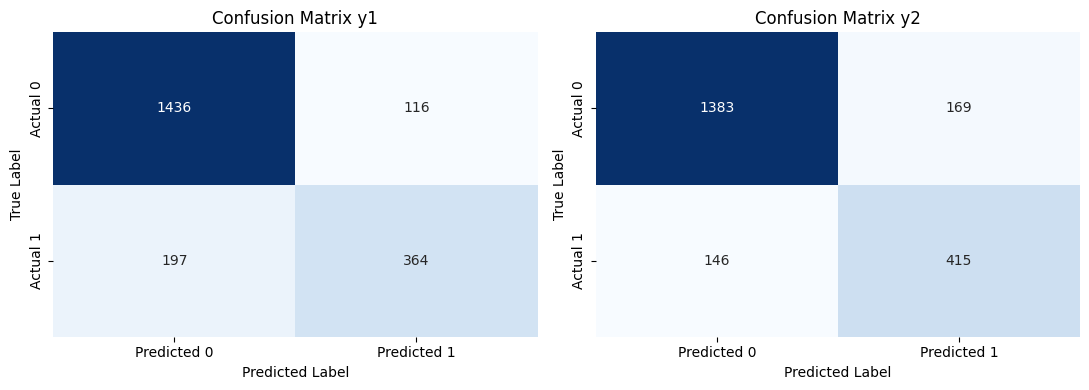

In [64]:
y_pred  = random_search.best_estimator_.predict(X_test)
y_pred1 = np.where(random_search.best_estimator_.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

# Create a confusion matrix
y_preds = {"y1" : y_pred , "y2": y_pred1}


fig, ax = plt.subplots(1,2, figsize=(11,4))
axes = ax.ravel()

for axes,y_values in zip(axes , y_preds):

    conf_matrix = confusion_matrix(y_test, y_preds[y_values])
    # Plot the confusion matrix using seaborn
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax = axes)
    axes.set_xlabel('Predicted Label')
    axes.set_ylabel('True Label')
    axes.set_title(f'Confusion Matrix {y_values}')

plt.tight_layout()

Changing the THRESHOLD value will cause a tradeoff between precision and recall, the client must decide

#### 3.7) Define a metrics function, to determine performance metrics

In [589]:

def calculate_metrics(conf_matrix):
    """
    Calculate various performance metrics from a confusion matrix.

    Parameters:
    - conf_matrix: 2x2 NumPy array, confusion matrix with rows representing actual classes
                  and columns representing predicted classes.

    Returns:
    - metrics_dict: Dictionary containing calculated performance metrics.
    """
    TP = conf_matrix[1, 1]  # True Positives
    TN = conf_matrix[0, 0]  # True Negatives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fpr = FP / (FP + TN)
    fdr = FP / (TP + FP)
    fnr = FN / (TP + FN)
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    # Create a dictionary to store the metrics
    metrics_dict = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1 Score': f1_score,
        'False Positive Rate (FPR)': fpr,
        'False Discovery Rate (FDR)': fdr,
        'False Negative Rate (FNR)': fnr,
        'Matthews Correlation Coefficient (MCC)': mcc,
    }

    return metrics_dict


#### 3.8) Calculate performance matrix for both THRESHOLD values

In [632]:
THRESHOLD = 0.4
y_pred1 = np.where(random_search.best_estimator_.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
y_pred2 = random_search.best_estimator_.predict(X_test)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred1)
conf_matrix2 = confusion_matrix(y_test, y_pred2)

print(calculate_metrics(conf_matrix))
print(calculate_metrics(conf_matrix2))

{'Accuracy': 0.8509228584950308, 'Precision': 0.711340206185567, 'Recall': 0.7379679144385026, 'Specificity': 0.8917525773195877, 'F1 Score': 0.7244094488188977, 'False Positive Rate (FPR)': 0.10824742268041238, 'False Discovery Rate (FDR)': 0.28865979381443296, 'False Negative Rate (FNR)': 0.2620320855614973, 'Matthews Correlation Coefficient (MCC)': 0.6224808958684382}
{'Accuracy': 0.8556554661618552, 'Precision': 0.7711864406779662, 'Recall': 0.6488413547237076, 'Specificity': 0.9304123711340206, 'F1 Score': 0.7047434656340755, 'False Positive Rate (FPR)': 0.06958762886597938, 'False Discovery Rate (FDR)': 0.2288135593220339, 'False Negative Rate (FNR)': 0.3511586452762923, 'Matthews Correlation Coefficient (MCC)': 0.6141448794302314}


### 4) Visualization of model important variables using <b>SHAP</b> package

#### 4.1) Calculate the shap values using best model

In [633]:
X1000 = shap.utils.sample(X_train, 1000)
explainer = shap.Explainer(random_search.best_estimator_.predict, X1000)
shap_values = explainer(X_train)

PermutationExplainer explainer: 4931it [06:31, 12.28it/s]                          


#### 4.2) Waterfall plot to observe the important variables for isolated values of <b>X</b>

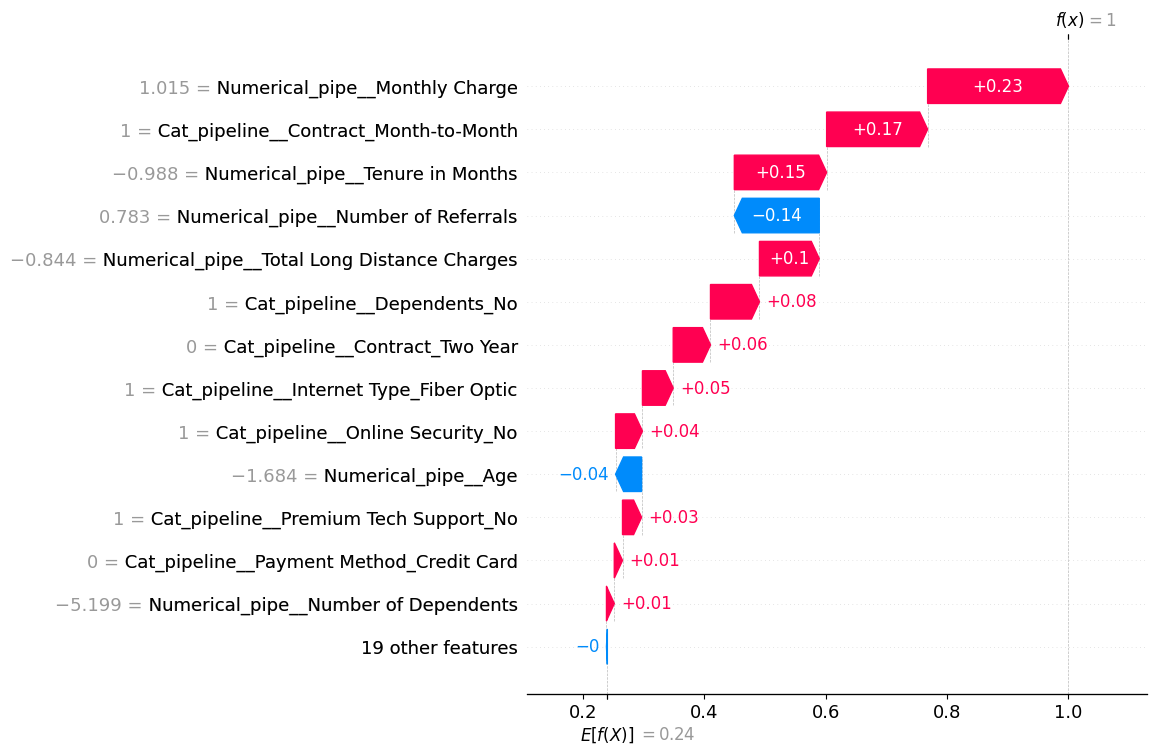

In [636]:
shap.plots.waterfall(shap_values[20], max_display=14)

#### 4.3) For a more global response analysis use beeswarm plot

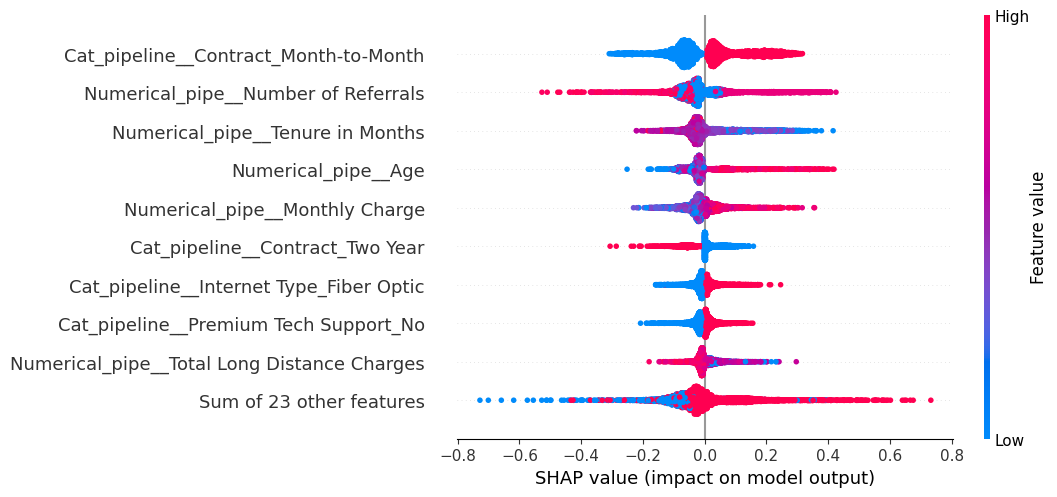

In [637]:
shap.plots.beeswarm(shap_values)

#### 4.3) The total effect is presented in the <b>summary_plot</b> of shap values

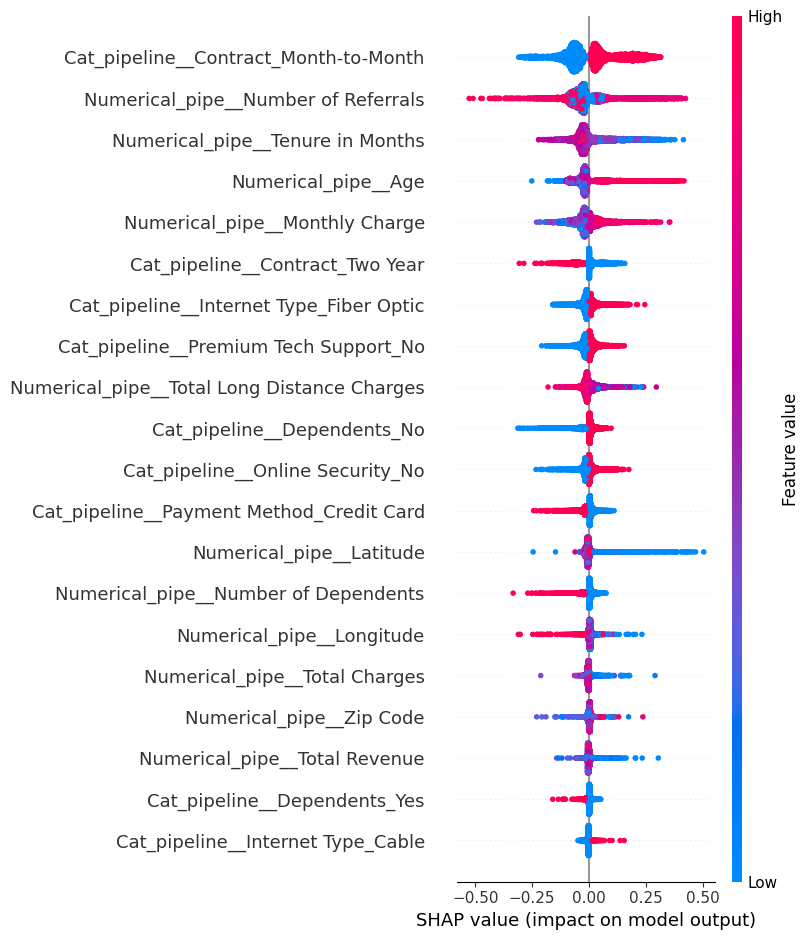

In [638]:
shap.summary_plot(shap_values)

For more interpretations, take in account that, variables that move wide to the right have a high impact in Churn rates, 
variables that move to the left side lower the Churn rates.

### 5) For comparison a Neural network for classification model is trained using <b>Pytorch</b>

#### 5.1) Import packages

In [639]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

#### 5.2) Transform dataframes to tensors

In [640]:
X_train_tensor = torch.FloatTensor(X_train.to_numpy(dtype='float32'))
y_train_tensor = torch.FloatTensor(y_train.to_numpy(dtype='float32').reshape(-1, 1))
X_test_tensor = torch.FloatTensor(X_test.to_numpy(dtype='float32'))
y_test_tensor = torch.FloatTensor(y_test.to_numpy(dtype='float32').reshape(-1, 1))


#### 5.3) Create ANN structures

In [641]:
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CustomNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define the Skorch wrapper for the neural network
class CustomNetClassifier(NeuralNetClassifier):
    def __init__(self, module, **kwargs):
        super(CustomNetClassifier, self).__init__(module, **kwargs)

# Create a Skorch classifier
classifier = CustomNetClassifier(
    module=CustomNN,
    module__input_size=X_train.shape[1],
    module__hidden_sizes=[16, 8],  # Specify the hidden layer sizes as needed
    module__output_size=1,
    max_epochs=50,  # Adjust the maximum number of epochs as needed
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.BCELoss,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=10)],
)


#### 5.4) Fit the model with gridsearchCV 

In [642]:
X_train_tensor = X_train_tensor.float()
y_train_tensor = y_train_tensor.float()

# Training the model
classifier.fit(X_train_tensor, y_train_tensor)

# Evaluate the model on the test set
accuracy = classifier.score(X_test_tensor, y_test_tensor)
print(f'Test Accuracy: {accuracy:.4f}')

# Example usage with GridSearchCV
params = {
    'lr': [0.05,0.1,0.2],
    'module__hidden_sizes': [[64,16],[64,32,16],[64,32],[128,64,32,16]],
}

grid = GridSearchCV(classifier, params, cv=3, scoring='accuracy', verbose=1)
grid.fit(X_train_tensor, y_train_tensor)
print(f'Best parameters: {grid.best_params_}')
print(f'Best accuracy: {grid.best_score_}')

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6936       0.6968        0.6401  0.1350
      2        0.6008       0.7353        0.5444  0.1390
      3        0.5172       0.7576        0.4678  0.1380
      4        0.4614       0.7961        0.4258  0.1402
      5        0.4346       0.8002        0.4049  0.1298
      6        0.4207       0.8063        0.3927  0.1150
      7        0.4113       0.8134        0.3839  0.1200
      8        0.4035       0.8225        0.3783  0.2140
      9        0.3969       0.8235        0.3744  0.1360
     10        0.3920       0.8195        0.3703  0.1260
     11        0.3882       0.8256        0.3677  0.1330
     12        0.3847       0.8235        0.3659  0.1240
     13        0.3824       0.8225        0.3642  0.1250
     14        0.3813       0.8306        0.3677  0.1110
     15        0.3796       0.8235        0.3627  0.1160
     16        0.3768       0.8

In [643]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(calculate_metrics(conf_matrix))


{'Accuracy': 0.8556554661618552, 'Precision': 0.7711864406779662, 'Recall': 0.6488413547237076, 'Specificity': 0.9304123711340206, 'F1 Score': 0.7047434656340755, 'False Positive Rate (FPR)': 0.06958762886597938, 'False Discovery Rate (FDR)': 0.2288135593220339, 'False Negative Rate (FNR)': 0.3511586452762923, 'Matthews Correlation Coefficient (MCC)': 0.6141448794302314}


#### 5.5) Plot AUC-ROC curve

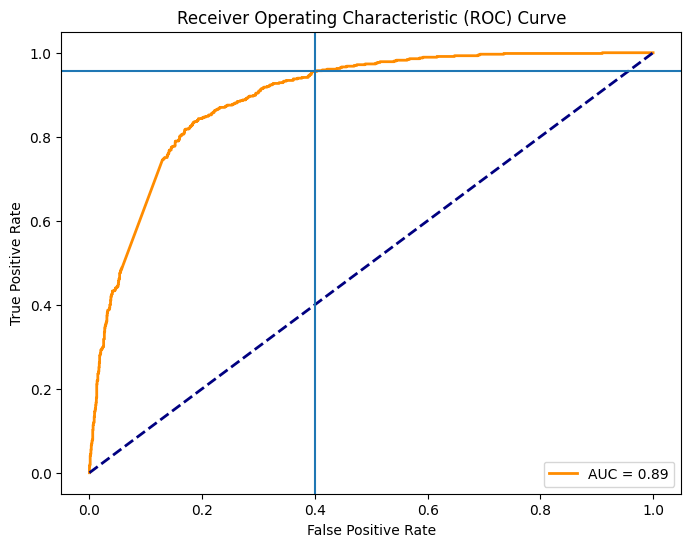

In [644]:
best_model = grid.best_estimator_
THRESHOLD = 0.4

# Predict probabilities on the test set
y_proba = best_model.predict_proba(X_test_tensor)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_tensor, y_proba)

roc_auc = auc(fpr, tpr)
app_prob = tpr[np.where(np.isclose(THRESHOLD, fpr,rtol=1e-2))]
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axhline(np.mean(app_prob))
plt.axvline(THRESHOLD)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 6) Make a decision tree to fit data, and fit a visualization about how clients works

#### 6.1) Import packages and fit the grid

In [645]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier()

# Define parameter grid
param_grid = {
    'criterion': ['gini'],  # Split criterion
    'max_depth': [5],  # Maximum depth of the tree
    'min_samples_split': [2],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [4],  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object
random_search = GridSearchCV(
    model,
    param_grid,
    scoring= "roc_auc",  # Replace 'custom_scorer' with the metric you want to use
    cv=5,  # Adjust the number of folds for cross-validation
    n_jobs=-1,  # Use parallel processing if possible
)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the performance
# You can use your custom scoring metric or other metrics like accuracy, precision, recall, etc.
# For example: print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [646]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(calculate_metrics(conf_matrix))


{'Accuracy': 0.8187411263606247, 'Precision': 0.7730061349693251, 'Recall': 0.44919786096256686, 'Specificity': 0.9523195876288659, 'F1 Score': 0.5682074408117249, 'False Positive Rate (FPR)': 0.04768041237113402, 'False Discovery Rate (FDR)': 0.22699386503067484, 'False Negative Rate (FNR)': 0.5508021390374331, 'Matthews Correlation Coefficient (MCC)': 0.4908633825612421}


#### 6.2) Plot AUC-ROC curve

Mean of empty slice.
invalid value encountered in scalar divide


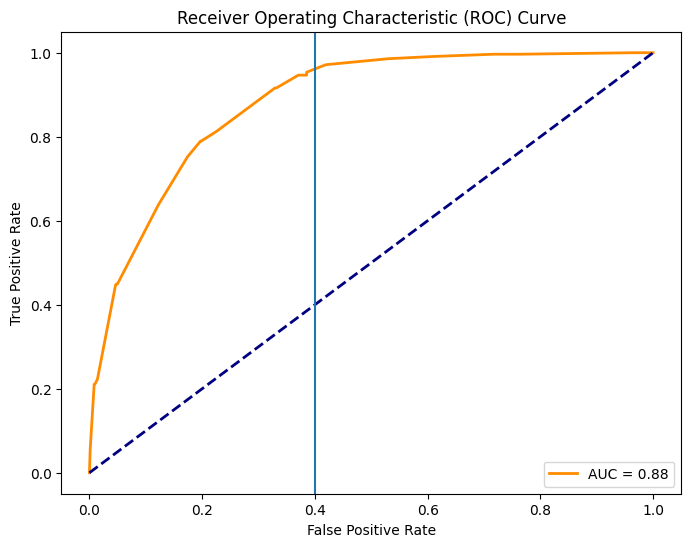

In [647]:
best_model = random_search.best_estimator_
THRESHOLD = 0.4

# Predict probabilities on the test set
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = auc(fpr, tpr)
app_prob = tpr[np.where(np.isclose(THRESHOLD, fpr,rtol=1e-2))]
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axhline(np.mean(app_prob))
plt.axvline(THRESHOLD)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### 6.3) Export decision tree diagram for a better understanding of data

In [475]:
import graphviz

model = DecisionTreeClassifier(criterion= "gini", max_depth= 5, min_samples_split= 2, min_samples_leaf=4)
model.fit(X_train,y_train)
X = Encoded_df
y = data_df.drop("Churn Value", axis=1)

dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=list(X.columns),
    class_names=[f'Class {i}' for i in set(y)],
    filled=True,
    rounded=True,
)

# Visualize the decision tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render('decision_tree', format='png', cleanup=True)  # Save as PNG or other formats
graph.view('decision_tree')  # Open the visualization in the default viewer

Error: Could not open "decision_tree.pdf" for writing : Permission denied


CalledProcessError: Command '[WindowsPath('dot'), '-Kdot', '-Tpdf', '-O', 'decision_tree']' returned non-zero exit status 1. [stderr: b'Error: Could not open "decision_tree.pdf" for writing : Permission denied\r\n']